# Exercise 1: Monte Carlo - Blackjack Policy Evaluation

## 1. Set up the Env't

In [29]:
#import Libraries
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

In [30]:
# Set up the Blackjack environment
env = gym.make('Blackjack-v1')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [31]:
# Define the policy: stick if sum >= 18, otherwise hit
def policy(state):
    player_sum, dealer_card, usable_ace = state
    return 0 if player_sum >= 18 else 1  # 0 = stick, 1 = hit

## 2. Task :

In [ ]:

# Monte Carlo Policy Evaluation
def monte_carlo_policy_evaluation(env, policy, num_episodes, gamma=1.0):
    # Initialize value function and returns
    V = defaultdict(float)
    returns = defaultdict(list)
    convergence_data = []  # To store V(s) over episodes

    for episode in range(num_episodes):
        # Generate an episode
        episode_history = []
        state = env.reset()
        done = False

        while not done:
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode_history.append((state, action, reward))
            state = next_state

        # Calculate returns and update value function
        G = 0
        for t in range(len(episode_history) - 1, -1, -1):
            state, _, reward = episode_history[t]
            G = gamma * G + reward
            if state not in [x[0] for x in episode_history[:t]]:  # First-visit MC
                returns[state].append(G)
                V[state] = np.mean(returns[state])

        # Track convergence for a specific state (e.g., (20, 10, False))
        if episode % 1000 == 0:
            convergence_data.append(V.get((20, 10, False), 0))  # Example state

    return V, convergence_data

In [ ]:
# Run Monte Carlo policy evaluation
num_episodes = 500000
V, convergence_data = monte_carlo_policy_evaluation(env, policy, num_episodes)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


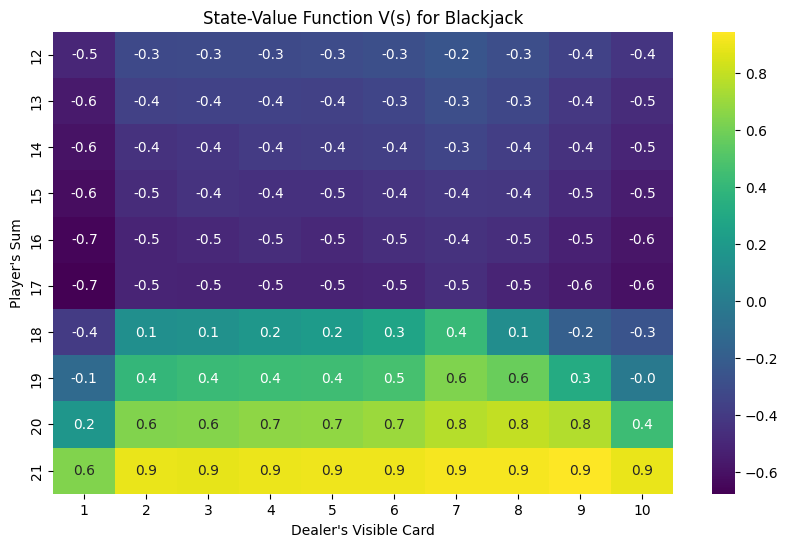

In [ ]:
# Create a heatmap of V(s)
def plot_value_function(V):
    player_sum_range = range(12, 22)
    dealer_card_range = range(1, 11)
    value_grid = np.zeros((len(player_sum_range), len(dealer_card_range)))

    for i, player_sum in enumerate(player_sum_range):
        for j, dealer_card in enumerate(dealer_card_range):
            state = (player_sum, dealer_card, False)  # No usable ace
            value_grid[i, j] = V.get(state, 0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(value_grid, xticklabels=dealer_card_range, yticklabels=player_sum_range, annot=True, fmt=".1f", cmap="viridis")
    plt.title("State-Value Function V(s) for Blackjack")
    plt.xlabel("Dealer's Visible Card")
    plt.ylabel("Player's Sum")
    plt.show()

# Plot the value function
plot_value_function(V)

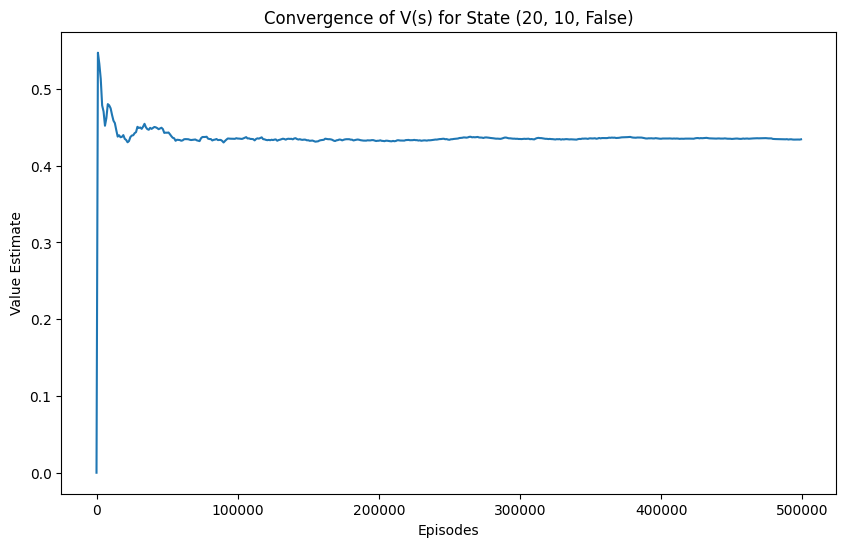

In [ ]:
# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(range(0, num_episodes, 1000), convergence_data)
plt.title("Convergence of V(s) for State (20, 10, False)")
plt.xlabel("Episodes")
plt.ylabel("Value Estimate")
plt.show()

### Using Dynamic Policy

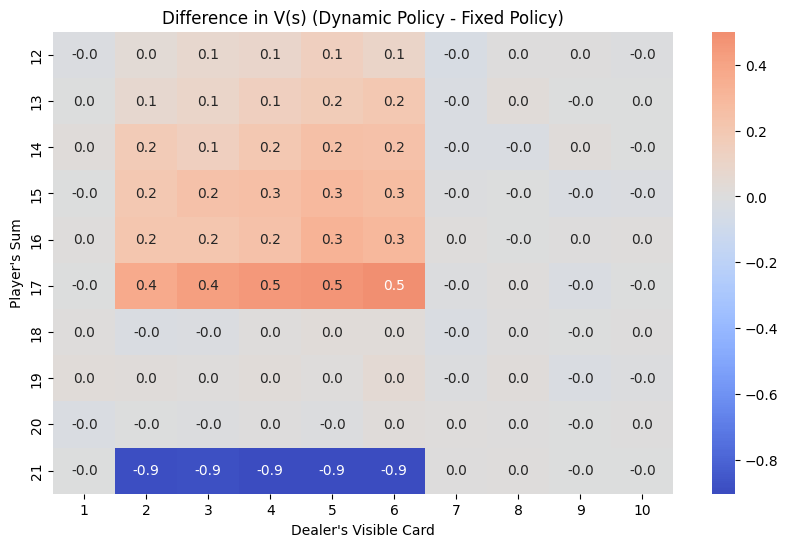

In [26]:
def dynamic_policy(state):
    player_sum, dealer_card, usable_ace = state
    # Stick if player_sum >= 18 or if dealer's card is low (2-6)
    if player_sum >= 18 or (dealer_card >= 2 and dealer_card <= 6):
        return 0  # Stick
    else:
        return 1  # Hit

# Evaluate dynamic policy
V_dynamic, _ = monte_carlo_policy_evaluation(env, dynamic_policy, num_episodes)

# Plot the difference between policies
def plot_policy_difference(V_fixed, V_dynamic):
    player_sum_range = range(12, 22)
    dealer_card_range = range(1, 11)
    difference_grid = np.zeros((len(player_sum_range), len(dealer_card_range)))

    for i, player_sum in enumerate(player_sum_range):
        for j, dealer_card in enumerate(dealer_card_range):
            state = (player_sum, dealer_card, False)  # No usable ace
            difference_grid[i, j] = V_dynamic.get(state, 0) - V_fixed.get(state, 0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(difference_grid, xticklabels=dealer_card_range, yticklabels=player_sum_range, annot=True, fmt=".1f", cmap="coolwarm", center=0)
    plt.title("Difference in V(s) (Dynamic Policy - Fixed Policy)")
    plt.xlabel("Dealer's Visible Card")
    plt.ylabel("Player's Sum")
    plt.show()

# Plot the difference
plot_policy_difference(V, V_dynamic)